In [60]:
# Standard Libraries
import copy
import itertools
import os
import time
from tempfile import TemporaryDirectory

# 3rd Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torchvision
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm

## 1) Custom Dataset to process labeled info (The data is already pre-processed and labeled from the segmentation driver). 

In [62]:
class CustomDataset(Dataset):
    """
    A custom dataset class that extends PyTorch's Dataset class for image loading and preprocessing.

    Attributes:
    - image_paths (list): List of paths to the images.
    - labels (list): List of labels corresponding to the images.
    - transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, image_paths, labels, transform=None):
        """
        Initializes the dataset with images and labels.

        Parameters:
        - image_paths (list): List of paths to the images.
        - labels (list): List of labels for the images.
        - transform (callable, optional): Optional transform to apply on images.
        """

        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """

        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Retrieves an image and its label from the dataset at the specified index.

        Parameters:
        - index (int): Index of the image and label to return.

        Returns:
        - tuple: A tuple containing the image and its label.
        """

        image_path = self.image_paths[index]
    
        # Print the image path for debugging
        # print(f"Accessing image: {image_path}")

        # Check if the file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"The file {image_path} does not exist.")

        # Attempt to open the image file
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            # If an error occurs, print the error and the problematic file path
            print(f"Error opening image at {image_path}: {e}")
            raise

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

### Helper functions to load / show data

In [63]:
# Function for displaying an image, currently not used in the main workflow
def imshow(inp, title=None):
    """
    Displays an image with an optional title.

    Parameters:
    - inp (Tensor): The image tensor to display.
    - title (str, optional): Optional title to display above the image.
    """

    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the plot

def load_data_from_pickle(file_path):
    """
    Load data from a pickle file.

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        tuple: A tuple containing the image paths and labels loaded from the pickle file.
    """
    with open(file_path, 'rb') as file:
        image_paths, labels = pickle.load(file)
    return image_paths, labels

## 2) Loading train/validation/test data paths and labels

In [64]:
# The data is split into 70% training, 15% validation, and 15% testing, accoridng to the segment and split that happens in the other file.
# The data is loaded from the pickle files

train_file = 'full_dataset_segmented_train_data.pkl'
val_file = 'full_dataset_segmented_val_data.pkl'
test_file = 'full_dataset_segmented_test_data.pkl'

train_paths, train_labels = load_data_from_pickle(train_file)
val_paths, val_labels = load_data_from_pickle(val_file)
test_paths, test_labels = load_data_from_pickle(test_file)

# And all combined ( to make sure the data is loaded correctly )
image_paths = train_paths + val_paths + test_paths
labels = train_labels + val_labels + test_labels

## 3) Data Augmentation

In [65]:
# Normalization parameters for the pre-trained models
normalization = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Define the training data transformations
training_transform = transforms.Compose([
    transforms.Resize(224, antialias=True),  # Resize images to 224 x 224 (instead of cropping, from ablation study results.)
    ### Taken out from ablation study results
    # transforms.RandomCrop(224),  # Crop randomly to 224x224 for data augmentation
    # transforms.RandomRotation(20),  # Rotate images up to 20 degrees for data augmentation
    transforms.RandomHorizontalFlip(0.1),  # Horizontally flip images with a probability of 0.1 for data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly adjust color settings
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Randomly adjust sharpness for data augmentation
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])

# Define the validation and test data transformations
transform = transforms.Compose([
    transforms.Resize(224, antialias=True),  # Resize images to 256x256, with antialiasing
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])

### To check the data is being processed correctly and labled correctly

In [66]:
labels_mapping = {'Trash': 0, 'Plastic': 1, 'Paper': 2, 'Metal': 3, 'Glass': 4, 'Cardboard': 5}
datasets_by_label = {}
data_loaders_by_label = {}

for label_name, label_id in labels_mapping.items():
    # Filter indices for the current label
    indices = [i for i, label in enumerate(labels) if label == label_id]

    # Use the indices to create a Subset
    subset = Subset(CustomDataset(image_paths, labels, transform=transform), indices)

    # Store the subset using the label_name as key
    datasets_by_label[label_name] = subset

    # Create a DataLoader for the current label's dataset
    data_loader = DataLoader(subset, batch_size=32, num_workers=1, shuffle=False)

    # Store the DataLoader using the label_name as key
    data_loaders_by_label[label_name] = data_loader

for label_name, subset in datasets_by_label.items():
    print(f"\nExamples from class: {label_name}")

    # Get the first few indices from the subset.indices
    example_indices = subset.indices[:5]  # Adjust the number of examples as needed

    for idx in example_indices:
        print(f"Path: {image_paths[idx]}, Label ID: {labels[idx]}")


Examples from class: Trash
Path: ../../data/dataset-resized\Trash\trash25.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash128.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash12.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash21.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash41.jpg, Label ID: 0

Examples from class: Plastic
Path: ../../data/dataset-resized\Plastic\plastic415.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic66.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic77.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic152.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic360.jpg, Label ID: 1

Examples from class: Paper
Path: ../../data/dataset-resized\Paper\paper88.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper40.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper343.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper466.jpg, Labe

## 4) Intializing model and defininig evaluation metric

In [67]:
def initialize_model(output_classes=6):
    """
    Initializes the ResNet-50 model pre-trained on ImageNet (just convolutional layers) and implements the final fully connected layer.

    Parameters:
    - output_classes (int): The number of classes for the final output layer.

    Returns:
    - model (torch.nn.Module): The modified model based on the pre-trained Resnet-50 feature representation.
    """

    # Load a pre-trained ResNet-50 model
    model = torchvision.models.resnet50(weights='IMAGENET1K_V1')

    # # Freeze all the parameters in the model to prevent them from being updated during training
    # for param in model.parameters():
    #     param.requires_grad = False

    # Get the number of input features to the final fully connected layer
    in_features = model.fc.in_features # 2048 input features (from the last feature mapping layer of Resnet)

    # Replace the final fully connected layer with a new one that has the desired number of output classes
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),  # Reduce dimension from in_features to 512
        nn.ReLU(),                    # Apply ReLU activation function
        nn.Linear(512, 6)  # Final layer with 'output_classes' number of outputs
    )

    return model

def evaluate_model(model, dataloader, loss_fun, device):
    """
    Evaluates the model's performance on a given dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: The DataLoader containing the dataset for evaluation.
    - loss_fun: The loss function used to compute the model's loss.
    - device: The device (CPU or CUDA) on which the computations will be performed.

    Returns:
    - A tuple of average loss and accuracy over the dataset.
    """

    model.eval()  # Set the model to evaluation mode    test_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the same device as the model

            pred = model(x)
            _, predicted_classes = torch.max(pred, 1)
            correct_predictions = (predicted_classes == y).float()

            loss = loss_fun(pred, y.long())  # Ensure consistent data type
            val_loss += loss.item()
            val_acc += correct_predictions.sum().item() / y.size(0)

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss, val_acc

def misclassified_labels(model, dataloader, device):
    """
    Identifies misclassified samples in the given dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: The DataLoader containing the dataset for evaluation.
    - device: The device (CPU or CUDA) on which the computations will be performed.

    Returns:
    - A list of tuples where each tuple contains the image path, actual label, and predicted label.
    """

    model.eval()  # Set the model to evaluation mode
    misclassified = []

    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Identify misclassified labels
            mismatches = predicted != labels
            for idx in torch.where(mismatches)[0]:
                actual_label = labels[idx].item()
                predicted_label = predicted[idx].item()
                image_path = dataloader.dataset.image_paths[idx]  # Assuming dataset has 'image_paths' attribute
                misclassified.append([idx.item(), predicted_label])

    return misclassified

# Usage example
num_classes = 6  # Define the number of output classes you need
example_model = initialize_model(num_classes)
print(example_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 5) Single Training loop defined 

In [68]:
def train(train_dataloader, val_dataloader, num_classes, N_epochs=10, lr=1e-5, step_size=5, gamma=0.5):
    """
    Trains and validates a model, saving the model with the best validation accuracy, and records the training and validation performance.

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - num_classes (int): Number of classes in the dataset.
    - N_epochs (int): Number of epochs to train for.
    - lr (float): Learning rate for the optimizer.
    - step_size (int): Step size for the learning rate scheduler.
    - gamma (float): Decay rate for the learning rate scheduler.

    Returns:
    - A dictionary containing the model with the best validation accuracy, training losses, training accuracies, validation losses, and validation accuracies.
    """

    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # If a CUDA-capable device is detected, print its name
    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    # Initialize the model and move it to the appropriate device
    model = initialize_model(num_classes)
    model.to(device)

    # Define the loss function and the optimizer
    loss_fun = nn.CrossEntropyLoss()
    loss_fun.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    # Define the learning rate scheduler
    lr_schedule = lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

    # Initialize lists to store the performance metrics
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Variable to keep track of the best validation accuracy
    best_acc = 0.0
    # Variable to store the model weights corresponding to the best validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in tqdm(range(N_epochs)):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Iterate over the training data
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the correct device
            pred = model(x)  # Forward pass: compute the model output
            loss = loss_fun(pred, y.long())  # Compute the loss
            optimizer.zero_grad()  # Zero the gradients to prevent accumulation
            loss.backward()  # Backward pass: compute the gradient of the loss with respect to model parameters
            optimizer.step()  # Update model parameters

            # Accumulate the training loss and correct predictions to calculate accuracy
            train_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            train_correct += (predicted == y).sum().item()
            total += y.size(0)

        # Compute the average training loss and accuracy for the epoch
        train_loss /= len(train_dataloader)
        train_acc = train_correct / total
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate_model(model, val_dataloader, loss_fun, device)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        # Check if the current model is the best one based on validation loss
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Update the learning rate
        lr_schedule.step()

        # Print the performance metrics for the epoch
        print(f"Epoch {epoch+1}/{N_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and performance metrics
    return {
        "model": model,
        "training_losses": training_losses,
        "training_accuracies": training_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies
    }

## 6) Grid search hyperparameters + main training loop. This is where the meat & potatoes are.
### Then, the best model is saved as a path file so it can be loaded later.
### During training, the best model is the epoch with the highest validation accuracy. Then, the grid search takes the model with the highest testing accuracy for the final best model.

In [69]:
# Create dataset objects for training, validation, and testing
train_dataset = CustomDataset(train_paths, train_labels, transform=training_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

# Define the hyperparameter grid
learning_rates = [5e-5, 5e-4]  # CV learning rates
batch_sizes = [32]  # CV batch sizes
num_epochs_list = [20]  # CV number of epochs
step_sizes = [4, 8]  # CV step sizes

# Record the best performance and metrics
best_acc = 0
best_hyperparams = None
best_model_info = {}

# Record time for compute calculations later.
start_time = time.time()

# VERY IMPORTANT TO BE AWARE OF THE FLUCTUATIONS IN THE GPU UTILIZATION AND THE PEAK PERFORMANCE.
# IF THIS IS BEING RUN SOMEWHERE ELSE THIS MUST BE UPDATED.
# THESE VALUES ARE FOR THE NVIDIA GEFORCE RTX 2080 NIKOLAJ'S COMP. NOT UNIVERSAL AND ALSO THE AVERAGE UTALIZATION IS A GUESS FROM MY EXPERIENCE WATCHING TASK MANAGER.
peak_performance_tflops = 9.76 # Hypothetical peak performance in TFLOP/s of NVIDIA GeForce RTX 3050 Ti
average_utilization = 0.20  # Assumed average (from my experience on task manager)

# Iterate over all combinations of hyperparameters
for lr, batch_size, num_epochs, step_size in itertools.product(learning_rates, batch_sizes, num_epochs_list, step_sizes):
    print(f"Training with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, step_size={step_size}")

    # Create data loaders for batching, shuffling, and iterating over the datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

    # Train the model with the current set of hyperparameters
    results = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_classes=6, N_epochs=num_epochs, lr=lr, step_size=step_size)
    model = results["model"]

    # Evaluate the model on the testing set
    loss_fun = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    test_loss, test_acc = evaluate_model(model, test_dataloader, loss_fun, device)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Save the model and metrics if it has the best accuracy so far on the testing set
    if test_acc > best_acc:
        best_acc = test_acc
        best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}
        best_model_info = {
            "state_dict": copy.deepcopy(model.state_dict()),
            "training_losses": results["training_losses"],
            "training_accuracies": results["training_accuracies"],
            "validation_losses": results["validation_losses"],
            "validation_accuracies": results["validation_accuracies"]
        }


end_time = time.time() # end time in seconds
total_time = end_time - start_time # total time in seconds
total_compute_units_tflops = peak_performance_tflops * average_utilization * total_time # total compute in TFLOP/s

# Convert TFLOPs to TFLOP-hours by dividing by the number of seconds in an hour
total_compute_units_tfloph = total_compute_units_tflops / 3600

print(f"Assuming peak performance of {peak_performance_tflops} TFLOP/s and average utilization of {average_utilization}:")
print(f"Total training time: {total_time} seconds")
print(f"Total compute units: {total_compute_units_tfloph} TFLOP-hours")

# Output the best performing set of hyperparameters based on the testing dataset
print(f"Best performing model on testing set: {best_hyperparams} with accuracy: {best_acc}")

# Save the best model and associated metrics
torch.save(best_model_info, 'ResNet50_best_model.pth')

Training with lr=5e-05, batch_size=32, num_epochs=20, step_size=4
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:59<18:49, 59.42s/it]

Epoch 1/20, Train Loss: 0.9456, Train Acc: 0.7126, Val Loss: 0.4204, Val Acc: 0.8646


 10%|█         | 2/20 [01:50<16:25, 54.75s/it]

Epoch 2/20, Train Loss: 0.2794, Train Acc: 0.9130, Val Loss: 0.2965, Val Acc: 0.9106


 15%|█▌        | 3/20 [02:42<15:06, 53.31s/it]

Epoch 3/20, Train Loss: 0.1033, Train Acc: 0.9712, Val Loss: 0.2803, Val Acc: 0.9167


 20%|██        | 4/20 [03:34<14:04, 52.80s/it]

Epoch 4/20, Train Loss: 0.0545, Train Acc: 0.9848, Val Loss: 0.2896, Val Acc: 0.9219


 25%|██▌       | 5/20 [04:26<13:06, 52.43s/it]

Epoch 5/20, Train Loss: 0.0334, Train Acc: 0.9938, Val Loss: 0.2938, Val Acc: 0.9323


 30%|███       | 6/20 [05:17<12:09, 52.14s/it]

Epoch 6/20, Train Loss: 0.0256, Train Acc: 0.9949, Val Loss: 0.2826, Val Acc: 0.9323


 35%|███▌      | 7/20 [06:09<11:17, 52.09s/it]

Epoch 7/20, Train Loss: 0.0195, Train Acc: 0.9960, Val Loss: 0.2780, Val Acc: 0.9375


 40%|████      | 8/20 [07:01<10:23, 51.96s/it]

Epoch 8/20, Train Loss: 0.0155, Train Acc: 0.9972, Val Loss: 0.2732, Val Acc: 0.9401


 45%|████▌     | 9/20 [07:53<09:30, 51.84s/it]

Epoch 9/20, Train Loss: 0.0088, Train Acc: 0.9989, Val Loss: 0.2891, Val Acc: 0.9323


 50%|█████     | 10/20 [08:44<08:37, 51.77s/it]

Epoch 10/20, Train Loss: 0.0088, Train Acc: 0.9989, Val Loss: 0.2663, Val Acc: 0.9401


 55%|█████▌    | 11/20 [09:36<07:46, 51.79s/it]

Epoch 11/20, Train Loss: 0.0099, Train Acc: 0.9989, Val Loss: 0.2959, Val Acc: 0.9323


 60%|██████    | 12/20 [10:35<07:11, 53.93s/it]

Epoch 12/20, Train Loss: 0.0120, Train Acc: 0.9972, Val Loss: 0.2595, Val Acc: 0.9401


 65%|██████▌   | 13/20 [11:27<06:14, 53.48s/it]

Epoch 13/20, Train Loss: 0.0053, Train Acc: 1.0000, Val Loss: 0.2539, Val Acc: 0.9479


 70%|███████   | 14/20 [12:19<05:17, 52.96s/it]

Epoch 14/20, Train Loss: 0.0122, Train Acc: 0.9966, Val Loss: 0.2709, Val Acc: 0.9401


 75%|███████▌  | 15/20 [13:11<04:23, 52.61s/it]

Epoch 15/20, Train Loss: 0.0092, Train Acc: 0.9983, Val Loss: 0.2680, Val Acc: 0.9453


 80%|████████  | 16/20 [14:07<03:34, 53.67s/it]

Epoch 16/20, Train Loss: 0.0060, Train Acc: 0.9994, Val Loss: 0.2692, Val Acc: 0.9427


 85%|████████▌ | 17/20 [15:01<02:41, 53.87s/it]

Epoch 17/20, Train Loss: 0.0054, Train Acc: 1.0000, Val Loss: 0.2764, Val Acc: 0.9453


 90%|█████████ | 18/20 [15:56<01:48, 54.07s/it]

Epoch 18/20, Train Loss: 0.0065, Train Acc: 1.0000, Val Loss: 0.2782, Val Acc: 0.9401


 95%|█████████▌| 19/20 [16:51<00:54, 54.25s/it]

Epoch 19/20, Train Loss: 0.0074, Train Acc: 0.9989, Val Loss: 0.2729, Val Acc: 0.9453


100%|██████████| 20/20 [17:41<00:00, 53.07s/it]

Epoch 20/20, Train Loss: 0.0065, Train Acc: 0.9994, Val Loss: 0.2729, Val Acc: 0.9479
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.1087, Test Accuracy: 0.9654
Training with lr=5e-05, batch_size=32, num_epochs=20, step_size=8
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:56<18:00, 56.87s/it]

Epoch 1/20, Train Loss: 0.9807, Train Acc: 0.6894, Val Loss: 0.4027, Val Acc: 0.8568


 10%|█         | 2/20 [01:47<15:57, 53.18s/it]

Epoch 2/20, Train Loss: 0.2478, Train Acc: 0.9305, Val Loss: 0.3237, Val Acc: 0.8993


 15%|█▌        | 3/20 [02:41<15:12, 53.68s/it]

Epoch 3/20, Train Loss: 0.0916, Train Acc: 0.9797, Val Loss: 0.2964, Val Acc: 0.9219


 20%|██        | 4/20 [03:28<13:36, 51.01s/it]

Epoch 4/20, Train Loss: 0.0553, Train Acc: 0.9893, Val Loss: 0.2879, Val Acc: 0.9193


 25%|██▌       | 5/20 [04:25<13:16, 53.11s/it]

Epoch 5/20, Train Loss: 0.0341, Train Acc: 0.9932, Val Loss: 0.3111, Val Acc: 0.9193


 30%|███       | 6/20 [05:12<11:55, 51.14s/it]

Epoch 6/20, Train Loss: 0.0259, Train Acc: 0.9938, Val Loss: 0.2981, Val Acc: 0.9323


 35%|███▌      | 7/20 [06:00<10:50, 50.01s/it]

Epoch 7/20, Train Loss: 0.0522, Train Acc: 0.9853, Val Loss: 0.4019, Val Acc: 0.8976


 40%|████      | 8/20 [06:44<09:38, 48.21s/it]

Epoch 8/20, Train Loss: 0.0553, Train Acc: 0.9870, Val Loss: 0.3334, Val Acc: 0.9193


 45%|████▌     | 9/20 [07:31<08:46, 47.82s/it]

Epoch 9/20, Train Loss: 0.0282, Train Acc: 0.9944, Val Loss: 0.2888, Val Acc: 0.9201


 50%|█████     | 10/20 [08:26<08:20, 50.01s/it]

Epoch 10/20, Train Loss: 0.0190, Train Acc: 0.9960, Val Loss: 0.2812, Val Acc: 0.9297


 55%|█████▌    | 11/20 [09:17<07:31, 50.22s/it]

Epoch 11/20, Train Loss: 0.0149, Train Acc: 0.9972, Val Loss: 0.2997, Val Acc: 0.9245


 60%|██████    | 12/20 [10:05<06:36, 49.60s/it]

Epoch 12/20, Train Loss: 0.0055, Train Acc: 0.9994, Val Loss: 0.2964, Val Acc: 0.9375


 65%|██████▌   | 13/20 [10:56<05:50, 50.04s/it]

Epoch 13/20, Train Loss: 0.0044, Train Acc: 1.0000, Val Loss: 0.2979, Val Acc: 0.9366


 70%|███████   | 14/20 [11:41<04:51, 48.51s/it]

Epoch 14/20, Train Loss: 0.0080, Train Acc: 0.9983, Val Loss: 0.2779, Val Acc: 0.9236


 75%|███████▌  | 15/20 [12:26<03:57, 47.45s/it]

Epoch 15/20, Train Loss: 0.0049, Train Acc: 0.9994, Val Loss: 0.2875, Val Acc: 0.9375


 80%|████████  | 16/20 [13:11<03:07, 46.76s/it]

Epoch 16/20, Train Loss: 0.0041, Train Acc: 0.9994, Val Loss: 0.2749, Val Acc: 0.9375


 85%|████████▌ | 17/20 [13:56<02:18, 46.17s/it]

Epoch 17/20, Train Loss: 0.0066, Train Acc: 0.9994, Val Loss: 0.2993, Val Acc: 0.9349


 90%|█████████ | 18/20 [14:41<01:31, 45.79s/it]

Epoch 18/20, Train Loss: 0.0034, Train Acc: 1.0000, Val Loss: 0.2892, Val Acc: 0.9349


 95%|█████████▌| 19/20 [15:26<00:45, 45.50s/it]

Epoch 19/20, Train Loss: 0.0030, Train Acc: 1.0000, Val Loss: 0.2958, Val Acc: 0.9349


100%|██████████| 20/20 [16:11<00:00, 48.55s/it]

Epoch 20/20, Train Loss: 0.0073, Train Acc: 0.9994, Val Loss: 0.2937, Val Acc: 0.9401
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.1185, Test Accuracy: 0.9550
Training with lr=0.0005, batch_size=32, num_epochs=20, step_size=4
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:44<14:13, 44.93s/it]

Epoch 1/20, Train Loss: 0.8826, Train Acc: 0.6770, Val Loss: 0.9957, Val Acc: 0.6832


 10%|█         | 2/20 [01:30<13:40, 45.57s/it]

Epoch 2/20, Train Loss: 0.5892, Train Acc: 0.7899, Val Loss: 0.6727, Val Acc: 0.7847


 15%|█▌        | 3/20 [02:16<12:57, 45.72s/it]

Epoch 3/20, Train Loss: 0.5666, Train Acc: 0.8029, Val Loss: 0.8641, Val Acc: 0.7179


 20%|██        | 4/20 [03:01<12:06, 45.42s/it]

Epoch 4/20, Train Loss: 0.4092, Train Acc: 0.8634, Val Loss: 0.5303, Val Acc: 0.8168


 25%|██▌       | 5/20 [03:48<11:28, 45.88s/it]

Epoch 5/20, Train Loss: 0.2144, Train Acc: 0.9305, Val Loss: 0.3772, Val Acc: 0.8863


 30%|███       | 6/20 [04:34<10:42, 45.88s/it]

Epoch 6/20, Train Loss: 0.1449, Train Acc: 0.9514, Val Loss: 0.6541, Val Acc: 0.8099


 35%|███▌      | 7/20 [05:19<09:54, 45.77s/it]

Epoch 7/20, Train Loss: 0.1311, Train Acc: 0.9616, Val Loss: 0.4678, Val Acc: 0.8681


 40%|████      | 8/20 [06:05<09:09, 45.81s/it]

Epoch 8/20, Train Loss: 0.1380, Train Acc: 0.9571, Val Loss: 0.3652, Val Acc: 0.8793


 45%|████▌     | 9/20 [06:51<08:22, 45.72s/it]

Epoch 9/20, Train Loss: 0.0622, Train Acc: 0.9797, Val Loss: 0.2879, Val Acc: 0.9210


 50%|█████     | 10/20 [07:36<07:35, 45.55s/it]

Epoch 10/20, Train Loss: 0.0396, Train Acc: 0.9881, Val Loss: 0.3097, Val Acc: 0.9132


 55%|█████▌    | 11/20 [08:21<06:49, 45.49s/it]

Epoch 11/20, Train Loss: 0.0494, Train Acc: 0.9848, Val Loss: 0.3127, Val Acc: 0.9002


 60%|██████    | 12/20 [09:07<06:03, 45.46s/it]

Epoch 12/20, Train Loss: 0.0290, Train Acc: 0.9921, Val Loss: 0.3180, Val Acc: 0.9158


 65%|██████▌   | 13/20 [09:52<05:18, 45.45s/it]

Epoch 13/20, Train Loss: 0.0277, Train Acc: 0.9915, Val Loss: 0.3168, Val Acc: 0.9210


 70%|███████   | 14/20 [10:37<04:32, 45.38s/it]

Epoch 14/20, Train Loss: 0.0247, Train Acc: 0.9915, Val Loss: 0.3362, Val Acc: 0.9210


 75%|███████▌  | 15/20 [11:23<03:46, 45.38s/it]

Epoch 15/20, Train Loss: 0.0180, Train Acc: 0.9949, Val Loss: 0.3636, Val Acc: 0.9184


 80%|████████  | 16/20 [12:08<03:01, 45.47s/it]

Epoch 16/20, Train Loss: 0.0237, Train Acc: 0.9932, Val Loss: 0.3039, Val Acc: 0.9227


 85%|████████▌ | 17/20 [12:58<02:20, 46.69s/it]

Epoch 17/20, Train Loss: 0.0168, Train Acc: 0.9944, Val Loss: 0.3165, Val Acc: 0.9340


 90%|█████████ | 18/20 [13:54<01:39, 49.54s/it]

Epoch 18/20, Train Loss: 0.0121, Train Acc: 0.9983, Val Loss: 0.3289, Val Acc: 0.9262


 95%|█████████▌| 19/20 [14:51<00:51, 51.61s/it]

Epoch 19/20, Train Loss: 0.0132, Train Acc: 0.9972, Val Loss: 0.3307, Val Acc: 0.9184


100%|██████████| 20/20 [15:47<00:00, 47.39s/it]

Epoch 20/20, Train Loss: 0.0088, Train Acc: 0.9977, Val Loss: 0.3278, Val Acc: 0.9236
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.2178, Test Accuracy: 0.9315
Training with lr=0.0005, batch_size=32, num_epochs=20, step_size=8
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:54<17:14, 54.42s/it]

Epoch 1/20, Train Loss: 0.9542, Train Acc: 0.6629, Val Loss: 2.7976, Val Acc: 0.5078


 10%|█         | 2/20 [01:50<16:34, 55.27s/it]

Epoch 2/20, Train Loss: 0.6633, Train Acc: 0.7668, Val Loss: 0.8276, Val Acc: 0.7578


 15%|█▌        | 3/20 [02:46<15:44, 55.53s/it]

Epoch 3/20, Train Loss: 0.5101, Train Acc: 0.8278, Val Loss: 0.7106, Val Acc: 0.7396


 20%|██        | 4/20 [03:42<14:51, 55.71s/it]

Epoch 4/20, Train Loss: 0.4250, Train Acc: 0.8577, Val Loss: 1.2757, Val Acc: 0.6311


 25%|██▌       | 5/20 [04:37<13:55, 55.72s/it]

Epoch 5/20, Train Loss: 0.3190, Train Acc: 0.8865, Val Loss: 0.6699, Val Acc: 0.7899


 30%|███       | 6/20 [05:33<12:59, 55.64s/it]

Epoch 6/20, Train Loss: 0.3439, Train Acc: 0.8865, Val Loss: 0.5559, Val Acc: 0.8299


 35%|███▌      | 7/20 [06:27<11:57, 55.21s/it]

Epoch 7/20, Train Loss: 0.2250, Train Acc: 0.9198, Val Loss: 0.5078, Val Acc: 0.8576


 40%|████      | 8/20 [07:23<11:03, 55.31s/it]

Epoch 8/20, Train Loss: 0.3174, Train Acc: 0.9046, Val Loss: 0.7837, Val Acc: 0.7804


 45%|████▌     | 9/20 [08:19<10:11, 55.61s/it]

Epoch 9/20, Train Loss: 0.1673, Train Acc: 0.9447, Val Loss: 0.3973, Val Acc: 0.8776


 50%|█████     | 10/20 [09:15<09:15, 55.60s/it]

Epoch 10/20, Train Loss: 0.0613, Train Acc: 0.9808, Val Loss: 0.4217, Val Acc: 0.8984


 55%|█████▌    | 11/20 [10:10<08:20, 55.63s/it]

Epoch 11/20, Train Loss: 0.0439, Train Acc: 0.9859, Val Loss: 0.4033, Val Acc: 0.8941


 60%|██████    | 12/20 [11:06<07:24, 55.62s/it]

Epoch 12/20, Train Loss: 0.0561, Train Acc: 0.9831, Val Loss: 0.4761, Val Acc: 0.8698


 65%|██████▌   | 13/20 [12:01<06:28, 55.45s/it]

Epoch 13/20, Train Loss: 0.0971, Train Acc: 0.9712, Val Loss: 0.4966, Val Acc: 0.8906


 70%|███████   | 14/20 [12:56<05:32, 55.50s/it]

Epoch 14/20, Train Loss: 0.0876, Train Acc: 0.9785, Val Loss: 0.4925, Val Acc: 0.8828


 75%|███████▌  | 15/20 [13:52<04:38, 55.64s/it]

Epoch 15/20, Train Loss: 0.0761, Train Acc: 0.9774, Val Loss: 0.5808, Val Acc: 0.8750


 80%|████████  | 16/20 [14:48<03:42, 55.72s/it]

Epoch 16/20, Train Loss: 0.0601, Train Acc: 0.9836, Val Loss: 0.5692, Val Acc: 0.8793


 85%|████████▌ | 17/20 [15:44<02:47, 55.83s/it]

Epoch 17/20, Train Loss: 0.0429, Train Acc: 0.9864, Val Loss: 0.3987, Val Acc: 0.9167


 90%|█████████ | 18/20 [16:40<01:51, 55.70s/it]

Epoch 18/20, Train Loss: 0.0389, Train Acc: 0.9898, Val Loss: 0.4173, Val Acc: 0.8984


 95%|█████████▌| 19/20 [17:35<00:55, 55.51s/it]

Epoch 19/20, Train Loss: 0.0195, Train Acc: 0.9927, Val Loss: 0.3891, Val Acc: 0.9141


100%|██████████| 20/20 [18:30<00:00, 55.50s/it]

Epoch 20/20, Train Loss: 0.0171, Train Acc: 0.9921, Val Loss: 0.4104, Val Acc: 0.9089
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.2364, Test Accuracy: 0.9267
Assuming peak performance of 9.76 TFLOP/s and average utilization of 0.2:
Total training time: 4116.603666543961 seconds
Total compute units: 2.2321139880816143 TFLOP-hours
Best performing model on testing set: {'lr': 5e-05, 'batch_size': 32, 'num_epochs': 20} with accuracy: 0.9654017857142857


## 7) Visualizing our best model

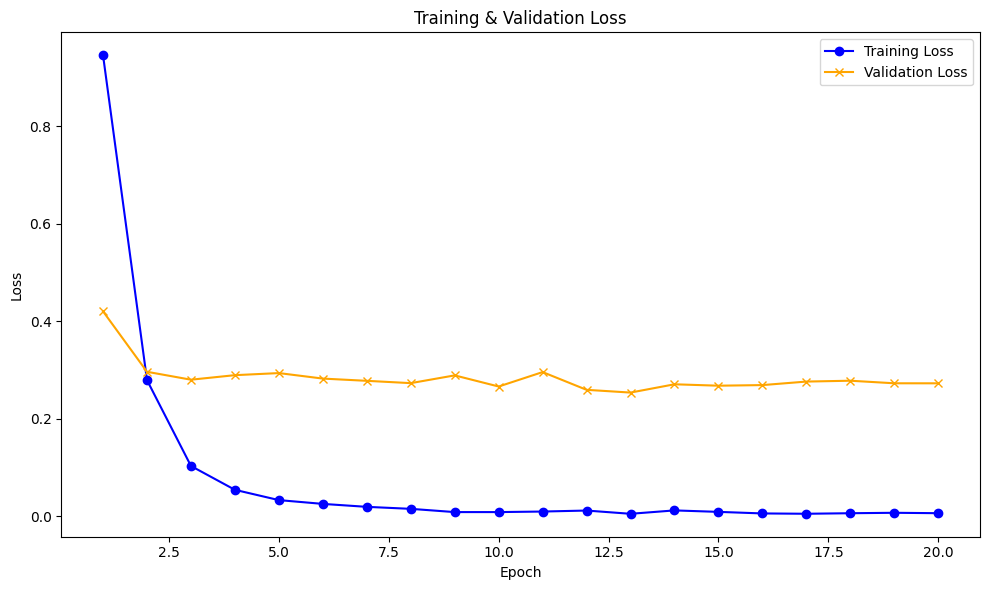

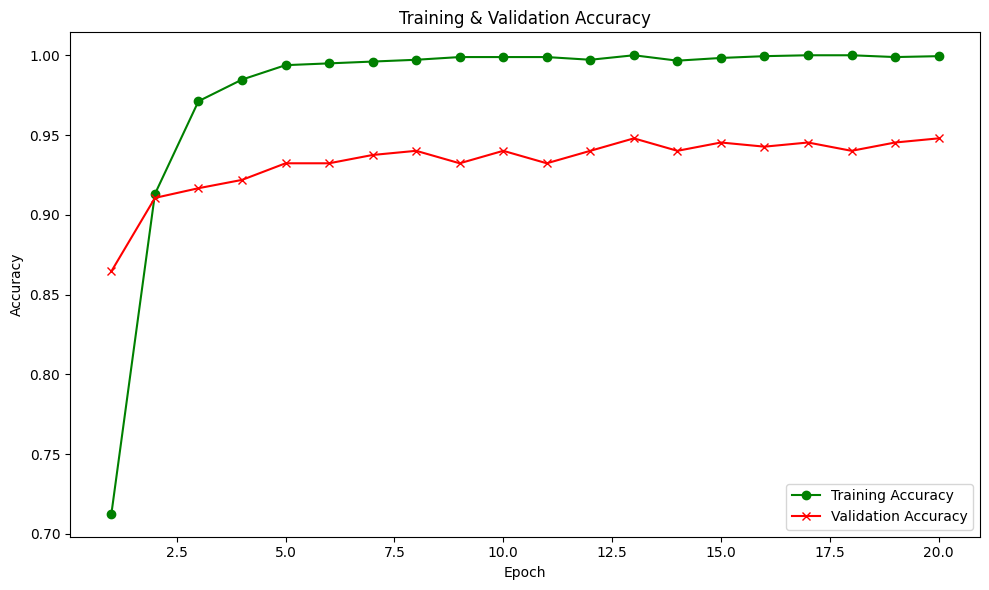

In [70]:
# Load the best model info
best_model_info = torch.load('ResNet50_best_model.pth')

# Extract the metrics from the loaded model info
training_losses = best_model_info['training_losses']
training_accuracies = best_model_info['training_accuracies']
validation_losses = best_model_info['validation_losses']
validation_accuracies = best_model_info['validation_accuracies']
num_epochs = len(training_losses)

# Define the epochs array
epochs = np.arange(1, num_epochs + 1)

# Define the colors for the plot
color_loss = 'blue'
color_val_loss = 'orange'
color_acc = 'green'
color_val_acc = 'red'

# Plot for Loss
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, training_losses, label='Training Loss', marker='o', color=color_loss)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='x', color=color_val_loss)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, training_accuracies, label='Training Accuracy', marker='o', color=color_acc)
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='x', color=color_val_acc)
plt.legend()
plt.tight_layout()
plt.show()

## 8) Showing which images in the test set the model failed to predict, and what it predicted in place.

In [71]:
# Load the best model from the saved state dictionary
num_classes = 6
categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']
best_model = initialize_model(num_classes)
best_model.load_state_dict(best_model_info['state_dict'])

# load the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_labels = test_dataset.labels
test_paths = test_dataset.image_paths

# Assuming device setup is already done (use CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Call the misclassified_labels function
misclassified_samples = misclassified_labels(best_model, test_dataloader, device)

# Print some of the misclassified samples to verify
for idx in misclassified_samples:
    dataloader_idx = idx[0]
    predicted_label = idx[1]
    print(f"Path to image: {test_paths[dataloader_idx]}, Actual label: {categories[test_labels[dataloader_idx]]}, Predicted label: {categories[predicted_label]}")


Path to image: ../../data/dataset-resized\Trash\trash92.jpg, Actual label: Trash, Predicted label: Cardboard
Path to image: ../../data/dataset-resized\Plastic\plastic436.jpg, Actual label: Plastic, Predicted label: Glass
Path to image: ../../data/dataset-resized\Trash\trash39.jpg, Actual label: Trash, Predicted label: Plastic
Path to image: ../../data/dataset-resized\Glass\glass182.jpg, Actual label: Glass, Predicted label: Plastic
Path to image: ../../data/dataset-resized\Glass\glass466.jpg, Actual label: Glass, Predicted label: Metal
Path to image: ../../data/dataset-resized\Paper\paper166.jpg, Actual label: Paper, Predicted label: Trash
Path to image: ../../data/dataset-resized\Cardboard\cardboard113.jpg, Actual label: Cardboard, Predicted label: Paper
Path to image: ../../data/dataset-resized\Metal\metal342.jpg, Actual label: Metal, Predicted label: Metal
Path to image: ../../data/dataset-resized\Metal\metal241.jpg, Actual label: Metal, Predicted label: Glass
Path to image: ../../d